# Water, wet vegetation and fractional cover polygon drill stack plot

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Jan 7, 2019 |
| Last edited: | Jan 10, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). The code snippets in this notebook will let you retrieve and plot the [Fractional Cover](https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF) (FC25) data stored in DEA.

__What does this notebook do?:__ This notebook takes a supplied shapefile of a polygon and queries the datacube for WOfS, Fractional Cover and NBART. It calculates thresholded tasselled cap wetness. The results are plotted against each other as a stacked plot for assessing change in wetlands or land cover. 
    
__How to use this notebook:__

A basic understanding of any programming language is desirable but one doesn't have to be an expert Python programmer to manipulate the code to get and display the data.This doc applies to the following Landsat satellites, Fractional Cover bands and the WOfS dataset:

- Landsat 5
- Landsat 7
- Landsat 8
- PV - Photosythetic vegetation
- NPV - Non-Photosythetic vegetation
- BS - Bare Soil
- WOfS Feature Layers (WOFLs)




__Future Work:__ 
- do this by max extent of wetness
- add rainfall for context
        

### import modules


In [3]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import os
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tci and wofs')

### Set up polygons

In [4]:
#path to polygon locations
polys_path = '/g/data/r78/rjd547/SA_mound_springs/'

### Run for all polygons in directory

Nilpinna.shp


<Figure size 432x288 with 0 Axes>

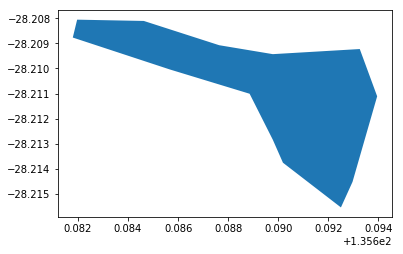

Loading ls5 pixel quality
    Loading 281 filtered ls5 timesteps


In [ ]:
polys = os.listdir(polys_path)

#print out the shapefile names in the directory
for filename in polys:
    if 'shp' in filename:
        print(filename)
        #get the name of the polygon from the shapefile
        polyname = filename.split('.')[0]

        #open the polygon
        with fiona.open(polys_path+filename) as shapes:
                crs = geometry.CRS(shapes.crs_wkt)
                first_geometry = next(iter(shapes))['geometry']
                geom = geometry.Geometry(first_geometry, crs=crs)

        #plot polygon to check it looks ok
        plt.clf()
        shape_plot = gpd.read_file(polys_path+filename)
        shape_plot.plot()
        plt.show()

        ### Set up query

        query = {'geopolygon': geom,
                 #'time': ('2016-01-01', '2018-06-30')
                 #'time': ('2007-01-01', '2007-06-30')
                 'time': ('1987-01-01', '2019-01-01')
                 }

        ## Set up datasets

        ### set cloudmasking threshold and load landsat nbart data

        #set cloudmasking threshold and load landsat nbart data
        landsat_masked_prop = 0.90
        ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
                masked_prop=landsat_masked_prop)

        ### mask the data with our original polygon to remove extra data 

        data = ls578_ds
        mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                                   out_shape=data.geobox.shape,
                                                   transform=data.geobox.affine,
                                                   all_touched=False,
                                                   invert=False)

        #for some reason xarray is not playing nicely with our old masking function
        mask_xr = xr.DataArray(mask, dims = ('y','x'))
        ls578_ds = data.where(mask_xr==False)

        #transform the nbart into tci
        tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

        ### create a masked version of the extent of overthreshold wetness

        #select only finite values (over threshold values)
        tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

        # #reapply the polygon mask
        tcw = tcw.where(mask_xr==False)

        ### load wofls and select only wet pixels

        #load wofs
        wofls = dc.load(product = 'wofs_albers', like=ls578_ds)

        #only get wet obs
        wetwofl = masking.make_mask(wofls, wet=True)

        #match the wofs observations to the nbart
        wetwofl=wetwofl.where(wofls.time==ls578_ds.time)

        ### mask the wofs obs

        #mask the wofs obs with the polygon mask
        wetwofl = wetwofl.where(mask_xr==False)

        ### load in fractional cover data

        #load the data according to our query
        #choose a mask proportion to look for a clear timestep
        fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

        ### mask FC with polygon

        fc_ds = fc_ds.where(mask_xr==False)

        ### mask FC with wetness

        fc_ds_noTCW=fc_ds.where(tcw==False)

        #set scene to plot
        scene =2

        #set up our images on a grid using gridspec
        plt.clf()
        plt.figure(figsize=(12,8))
        gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

        ax1=plt.subplot(gs[0,0])
        fc_ds_noTCW.PV.isel(time=scene).plot(cmap='gist_earth_r')
        ax1.set_title('PV')

        ax2=plt.subplot(gs[1,0])
        fc_ds_noTCW.BS.isel(time=scene).plot(cmap='Oranges')
        ax2.set_title('BS')

        ax3=plt.subplot(gs[0,1])
        fc_ds_noTCW.NPV.isel(time=scene).plot(cmap='copper')
        ax3.set_title('NPV')

        ax4=plt.subplot(gs[1,1])
        fc_ds_noTCW.UE.isel(time=scene).plot(cmap='magma')
        ax4.set_title('UE')

        plt.tight_layout()
        plt.show()

        ### Calculate number of pixels in area of interest

        #number of pixels in area of interest
        pixels = (mask_xr==0).sum(dim=['x','y'])

        mask_xr==0
        mask_xr.count(dim=['x','y'])

        #count number of wofs pixels
        wofs_pixels = wetwofl.water.sum(dim=['x','y'])

        #count percentage of area of wofs
        wofs_area_percent = (wofs_pixels/pixels)*100

        #count number of tcw pixels
        tcw_pixel_count = tcw.sum(dim=['x','y'])

        #calculate percentage area wet
        tcw_area_percent = (tcw_pixel_count/pixels)*100

        #calculate wet not wofs
        tcw_less_wofs = tcw_area_percent-wofs_area_percent

        ### Calculate the dominant fraction for each pixel in Fractional Cover

        #drop data percentage and Unmixing Error
        fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

        #following robbi's advice, cast the dataset to a dataarray
        maxFC = fc_tester.to_array(dim='variable', name='maxFC')

        #turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
        FC_int = maxFC.astype('int8')

        #use numpy.nanargmax to get the index of the maximum value along the variable dimension
        #BSPVNPV=np.nanargmax(FC_int, axis=0)
        BSPVNPV=FC_int.argmax(dim='variable')

        FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

        # #re-mask with nans to remove no-data
        BSPVNPV=BSPVNPV.where(FC_mask)

        #plot the results to check they look roughly like what we are expecting
        plt.clf()
        plt.imshow(BSPVNPV[2])
        plt.colorbar()

        FC_dominant = xr.Dataset({
            'BS': (BSPVNPV==0).where(FC_mask),
            'PV': (BSPVNPV==1).where(FC_mask),
            'NPV': (BSPVNPV==2).where(FC_mask),
        })

        FC_count = FC_dominant.sum(dim=['x','y'])

        #Fractional cover pixel count method
        #Get number of FC pixels, divide by total number of pixels per polygon

        Bare_soil_percent=(FC_count.BS/pixels)*100

        Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

        NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

        NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

        query['time'][0]

        #set up color palette
        pal = [sns.xkcd_rgb["cobalt blue"],
               sns.xkcd_rgb["neon blue"],
               sns.xkcd_rgb["grass"],
               sns.xkcd_rgb["beige"],
               sns.xkcd_rgb["brown"]]#,
              #sns.xkcd_rgb["grey"]]

        #make a stacked area plot
        plt.clf()
        plt.figure(figsize = (12,6))
        plt.stackplot(wofs_area_percent.time.values, 
                      wofs_area_percent, 
                      tcw_less_wofs, 
                      Photosynthetic_veg_percent, 
                      NonPhotosynthetic_veg_percent,
                      Bare_soil_percent,
                      NoData,
                      labels=['open water',
                              'wet',
                              'PV',
                              'NPV',
                              'BS'#,
                              #'NoData'
                             ], colors=pal, alpha = 0.6)

        plt.title('Percentage of area WOfS, Wetness, Fractional Cover')

        #set axis limits to the min and max
        plt.axis(xmin = query['time'][0], xmax = query['time'][1], ymin = 0, ymax = 100)

        #set date ticks every year
        years = mdates.YearLocator(2)
        yearsFmt = mdates.DateFormatter('%Y')
        ax = plt.gca()
        ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)

        #add a legend and a tight plot box
        plt.legend(loc='upper right')
        plt.tight_layout()

        #save the figure
        plt.savefig(f'/g/data/r78/rjd547/SA_mound_springs/{polyname}.png')#, transparent=True)
        plt.show()